In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
from IPython import display

import gym.spaces
import gym
import FastSLAM

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

In [2]:
N_eps = 20000
sim_time = 10.0

gamma = 0.9
seed = 0
_render = False
log_interval = 10
num_actions = 3
action_deg = 5

torch.manual_seed(seed)

TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward', 'score'])
Transition = namedtuple('Transition', ['s', 'a', 'a_p', 'r', 's_'])

In [3]:
class ActorNet(nn.Module):

    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Linear(148, 256)
        self.fc2 = nn.Linear(256, 256)
        self.a_head = nn.Linear(256, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_score = self.a_head(x)
        return F.softmax(action_score, dim=-1)


class CriticNet(nn.Module):

    def __init__(self):
        super(CriticNet, self).__init__()
        self.fc1 = nn.Linear(148, 256)
        self.fc2 = nn.Linear(256, 256)
        self.v_head = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        state_value = self.v_head(x)
        return state_value

In [4]:
class Agent():

#     action_list = [(i * 4 - 2,) for i in range(num_actions)]
    action_list = [(-np.deg2rad(action_deg),), (0,), (np.deg2rad(action_deg),)]
    clip_param = 0.2
    max_grad_norm = 0.5
    ppo_epoch = 10
    buffer_capacity, batch_size = 1000, 32

    def __init__(self):
        self.training_step = 0
        self.anet = ActorNet().float()
        self.cnet = CriticNet().float()

        self.buffer = []
        self.counter = 0

        self.optimizer_a = optim.Adam(self.anet.parameters(), lr=1e-3)
        self.optimizer_c = optim.Adam(self.cnet.parameters(), lr=3e-3)

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.anet(state)
        m = Categorical(probs)
        action = m.sample()
        return self.action_list[action.item()], action.item(), probs[:, action].item()

    def store(self, transition):
        self.buffer.append(transition)
        self.counter += 1
        return self.counter % self.buffer_capacity == 0

    def update(self):
        self.training_step += 1

        s = torch.tensor([t.s for t in self.buffer], dtype=torch.float)
        a = torch.tensor([t.a for t in self.buffer], dtype=torch.long).view(-1, 1)
        r = torch.tensor([t.r for t in self.buffer], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in self.buffer], dtype=torch.float)
        old_action_probs = torch.tensor([t.a_p for t in self.buffer], dtype=torch.float).view(-1, 1)

        r = (r - r.mean()) / (r.std() + 1e-5)

        with torch.no_grad():
            target_v = r + gamma * self.cnet(s_)
        adv = (target_v - self.cnet(s)).detach()

        for _ in range(self.ppo_epoch):
            for index in BatchSampler(
                    SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, False):
                action_probs = self.anet(s[index]).gather(1, a[index])
                ratio = action_probs / old_action_probs[index]

                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param,
                                    1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                self.optimizer_a.zero_grad()
                action_loss.backward()
                nn.utils.clip_grad_norm_(self.anet.parameters(), self.max_grad_norm)
                self.optimizer_a.step()

                value_loss = F.smooth_l1_loss(self.cnet(s[index]), target_v[index])
                self.optimizer_c.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(self.cnet.parameters(), self.max_grad_norm)
                self.optimizer_c.step()

        del self.buffer[:]

In [5]:
env = gym.make('FastSLAM-v0')
# env.seed(seed)

agent = Agent()

training_records = []
running_reward = 0

for i_ep in range(N_eps):
    score = 0
    state = env.reset()
    env.reward_type = 'Error'
    
    while env.time <= sim_time:
        action, action_index, action_prob = agent.select_action(state)
        state_, reward, done, _ = env.step(action[0])
        if _render:
            env.render_world()
            display.clear_output(wait=True)
            plt.pause(0.001)
#         if agent.store(Transition(state, action_index, action_prob, (reward + 8) / 8, state_)):
        if agent.store(Transition(state, action_index, action_prob, reward, state_)):
            agent.update()
        score += reward
        state = state_

    running_reward = running_reward * 0.9 + score * 0.1
    training_records.append(TrainingRecord(i_ep, running_reward, score))

    if i_ep % log_interval == 0:
        print('Ep {}\tMoving average score: {:.2f}\t'.format(i_ep, running_reward))
#     if running_reward > -200:
#         print("Solved! Moving average score is now {}!".format(running_reward))
#         env.close()
#         break

Ep 0	Moving average score: 0.21	
Ep 10	Moving average score: 1.95	
Ep 20	Moving average score: 1.93	
Ep 30	Moving average score: 2.06	
Ep 40	Moving average score: 2.35	
Ep 50	Moving average score: 2.48	
Ep 60	Moving average score: 1.73	
Ep 70	Moving average score: 2.26	
Ep 80	Moving average score: 1.95	
Ep 90	Moving average score: 1.72	
Ep 100	Moving average score: 2.12	
Ep 110	Moving average score: 1.97	
Ep 120	Moving average score: 1.96	
Ep 130	Moving average score: 1.99	
Ep 140	Moving average score: 1.56	
Ep 150	Moving average score: 1.87	
Ep 160	Moving average score: 2.44	
Ep 170	Moving average score: 2.09	
Ep 180	Moving average score: 2.22	
Ep 190	Moving average score: 1.87	
Ep 200	Moving average score: 2.49	
Ep 210	Moving average score: 2.16	
Ep 220	Moving average score: 2.13	
Ep 230	Moving average score: 1.97	
Ep 240	Moving average score: 2.21	
Ep 250	Moving average score: 2.28	
Ep 260	Moving average score: 2.44	
Ep 270	Moving average score: 2.33	
Ep 280	Moving average score: 2.

Ep 2310	Moving average score: 2.18	
Ep 2320	Moving average score: 1.97	
Ep 2330	Moving average score: 2.53	
Ep 2340	Moving average score: 2.32	
Ep 2350	Moving average score: 1.91	
Ep 2360	Moving average score: 1.93	
Ep 2370	Moving average score: 2.40	
Ep 2380	Moving average score: 2.17	
Ep 2390	Moving average score: 2.18	
Ep 2400	Moving average score: 2.03	
Ep 2410	Moving average score: 2.12	
Ep 2420	Moving average score: 2.02	
Ep 2430	Moving average score: 1.95	
Ep 2440	Moving average score: 2.27	
Ep 2450	Moving average score: 2.04	
Ep 2460	Moving average score: 2.08	
Ep 2470	Moving average score: 2.07	
Ep 2480	Moving average score: 2.41	
Ep 2490	Moving average score: 2.29	
Ep 2500	Moving average score: 2.60	
Ep 2510	Moving average score: 3.16	
Ep 2520	Moving average score: 2.78	
Ep 2530	Moving average score: 2.04	
Ep 2540	Moving average score: 2.22	
Ep 2550	Moving average score: 2.45	
Ep 2560	Moving average score: 1.78	
Ep 2570	Moving average score: 1.85	
Ep 2580	Moving average score

Ep 4590	Moving average score: 2.21	
Ep 4600	Moving average score: 2.30	
Ep 4610	Moving average score: 1.86	
Ep 4620	Moving average score: 2.24	
Ep 4630	Moving average score: 2.06	
Ep 4640	Moving average score: 1.95	
Ep 4650	Moving average score: 2.07	
Ep 4660	Moving average score: 1.99	
Ep 4670	Moving average score: 2.11	
Ep 4680	Moving average score: 2.09	
Ep 4690	Moving average score: 2.26	
Ep 4700	Moving average score: 2.40	
Ep 4710	Moving average score: 2.64	
Ep 4720	Moving average score: 2.10	
Ep 4730	Moving average score: 1.96	
Ep 4740	Moving average score: 2.19	
Ep 4750	Moving average score: 2.02	
Ep 4760	Moving average score: 1.98	
Ep 4770	Moving average score: 2.23	
Ep 4780	Moving average score: 2.17	
Ep 4790	Moving average score: 2.44	
Ep 4800	Moving average score: 1.89	
Ep 4810	Moving average score: 2.14	
Ep 4820	Moving average score: 2.20	
Ep 4830	Moving average score: 1.67	
Ep 4840	Moving average score: 1.62	
Ep 4850	Moving average score: 1.79	
Ep 4860	Moving average score

KeyboardInterrupt: 

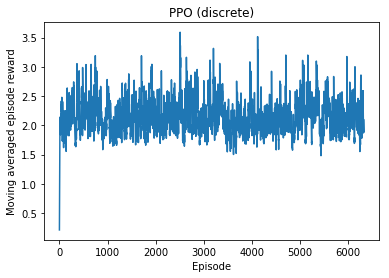

In [7]:
env.close()
plt.plot([r.ep for r in training_records], [r.reward for r in training_records])
# plt.plot([r.ep for r in training_records], [r.score for r in training_records])
plt.title('PPO (discrete)')
plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
plt.show()